In [79]:
import os

interface_dir = os.environ["DATA"] + "webinterfaces/exp02/"

tasks_dir = os.path.join(interface_dir, "res", "tasks")
results_dir = os.path.join(interface_dir, "results")
protocols_dir = os.path.join(interface_dir, "protocols")
prolific_matching_dir = os.path.join(interface_dir, "prolific")

protocol_paths_d = {
    "H": os.path.join(protocols_dir, "H_0.json"),
    "H+AI": os.path.join(protocols_dir, "AI_0.json"),
    "H+AI+CF": os.path.join(protocols_dir, "XAI_CF_0.json"),
    "H+AI+SHAP": os.path.join(protocols_dir, "XAI_SHAP_0.json"),
    "H+AI+LLM": os.path.join(protocols_dir, "XAI_LLM_0.json"),
    "H+AI+GRADCAM": os.path.join(protocols_dir, "XAI_GRADCAM_0.json"),
}

COMPREHENSION_THRESHOLD = 0.8

COMPREHENSION_TASKS = ["xeasy1_find_pattern_rot"]
TRAINING_TASKS = ["med3_find_pattern_rot"]
EASY_TASKS = ["easy1_find_pattern_rot", "easy3_find_pattern_rot"]
DIFFICULT_TASKS = ["hard1_find_pattern_rot", "hard3_find_pattern_rot"]

MILD_PRESSURE_TASKS = ["easy1_find_pattern_rot", "hard1_find_pattern_rot"]
STRONG_PRESSURE_TASKS = ["easy3_find_pattern_rot", "hard3_find_pattern_rot"]

TASK_PROTOCOL_KEYS = {
    "easy1_find_pattern_rot": "mainexp_easy_mild_patrot_task",
    "easy3_find_pattern_rot": "mainexp_easy_strong_patrot_task",

    "hard1_find_pattern_rot": "mainexp_hard_mild_patrot_task",
    "hard3_find_pattern_rot": "mainexp_hard_strong_patrot_task",

    "xeasy1_find_pattern_rot": "intro_comprehension_task",
    "med3_find_pattern_rot": "intro_training_1_task"
}


In [80]:
import sys

sys.path.append("/home/jleguy/Documents/postdoc/git_repos/WebXAII/")

In [81]:
import json
import csv
import numpy as np


def load_json(path):
    with open(path) as json_file:
        return json.load(json_file)


def load_task_csv_file(path):
    y_true, y_pred = [], []
    with open(path) as csv_data:
        reader = csv.DictReader(csv_data)
        for row in reader:
            y_true.append(int(row["target"]))
            y_pred.append(int(row["pred"]))

    return np.array(y_true), np.array(y_pred)


In [82]:
import json

def data_matching(protocols_paths_d, prolific_matching_files):

    results_filenames_d = {k: [] for k in protocol_paths_d.keys()}

    for prolific_matching_file in prolific_matching_files:

        with open(prolific_matching_file) as json_data:
            d = json.load(json_data)

            for prolific_id, prot_dict in d.items():
                condition_split = prot_dict["protocol"].split("_")
                filename = prolific_id + ".json"

                if condition_split[0] == "H":
                    results_filenames_d["H"].append(filename)
                elif condition_split[0] == "AI":
                    results_filenames_d["H+AI"].append(filename)
                elif condition_split[0] == "XAI" and condition_split[1] == "SHAP":
                    results_filenames_d["H+AI+SHAP"].append(filename)
                elif condition_split[0] == "XAI" and condition_split[1] == "CF":
                    results_filenames_d["H+AI+CF"].append(filename)
                elif condition_split[0] == "XAI" and condition_split[1] == "LLM":
                    results_filenames_d["H+AI+LLM"].append(filename)
                elif condition_split[0] == "XAI" and condition_split[1] == "GRADCAM":
                    results_filenames_d["H+AI+GRADCAM"].append(filename)

    return results_filenames_d


In [83]:
from pywebxaii.resretrieval import extract_p_questionnaire_results, get_protocol_entry_from_key

def extract_quest_results(results_dir, results_filenames_d, protocol_paths_d, quest_keys):
    output_res_d = {}

    # Iterating over all groups
    for group_key, filenames_list in results_filenames_d.items():

        output_res_d[group_key] = {"raw": {}, "values": {}, "times": {}}

        # Iterating on all results files for the current group
        for filename in filenames_list:
            # print(filename)
            curr_res_path = os.path.join(results_dir, filename)
            curr_res_d = load_json(curr_res_path)
            data_issue = False
            if not curr_res_d["is_completed"]:
                data_issue = True

            # Iterating over all questionnaires keys
            for quest_key in quest_keys:

                curr_protocol_d = load_json(protocol_paths_d[group_key])
                try:
                    get_protocol_entry_from_key(curr_protocol_d, quest_key)
                    answers_raw, answers_values, quest_times = extract_p_questionnaire_results(curr_res_d,
                                                                                               quest_key,
                                                                                               protocol_d=curr_protocol_d)
                except KeyError:
                    data_issue = True

                if quest_key not in output_res_d[group_key]["raw"]:
                    output_res_d[group_key]["raw"][quest_key] = []
                    output_res_d[group_key]["values"][quest_key] = []
                    output_res_d[group_key]["times"][quest_key] = []

                if data_issue:
                    output_res_d[group_key]["raw"][quest_key].append(None)
                    output_res_d[group_key]["values"][quest_key].append(None)
                    output_res_d[group_key]["times"][quest_key].append(None)
                else:
                    output_res_d[group_key]["raw"][quest_key].append(answers_raw)
                    output_res_d[group_key]["values"][quest_key].append(answers_values)
                    output_res_d[group_key]["times"][quest_key].append(quest_times)

    return output_res_d

In [84]:
from pywebxaii.resretrieval import extract_p_task_results


def compute_scores(results_dir, results_filenames_d, protocol_paths_d, tasks_dir, tasks_names, task_protocol_keys):
    output_res_scores_d = {}
    output_res_reliance_d = {}
    output_res_overreliance_d = {}
    output_res_underreliance_d = {}
    output_res_appropriate_reliance_d = {}
    output_res_answer_times_d = {}

    # Iterating over all groups
    for group_key, filenames_list in results_filenames_d.items():

        output_res_scores_d[group_key] = []
        output_res_reliance_d[group_key] = []
        output_res_overreliance_d[group_key] = []
        output_res_underreliance_d[group_key] = []
        output_res_appropriate_reliance_d[group_key] = []
        output_res_answer_times_d[group_key] = []

        # Iterating on all results files for the current group
        for filename in filenames_list:
            curr_res_path = os.path.join(results_dir, filename)
            curr_res_d = load_json(curr_res_path)
            if not curr_res_d["is_completed"]:
                continue

            nb_questions = 0
            nb_quest_wrong_predictions = 0
            nb_quest_right_predictions = 0
            nb_correct = 0
            nb_reliance = 0
            nb_overreliance = 0
            nb_underreliance = 0
            nb_appropriate = 0
            answer_times = []
            early_break = False

            # Iterating over all tasks
            for task_idx, task_name in enumerate(tasks_names):

                task_true, ai_pred = load_task_csv_file(os.path.join(tasks_dir, task_name + "_content.csv"))

                answers_idx_vect, answers_text_vect, time_vect, _, _ = \
                    extract_p_task_results(curr_res_d,
                                           task_protocol_keys[tasks_names[task_idx]],
                                           protocol_d=load_json(protocol_paths_d[group_key]))

                nb_questions += len(answers_idx_vect)
                nb_quest_wrong_predictions += np.sum(task_true != ai_pred)
                nb_quest_right_predictions += np.sum(task_true == ai_pred)

                try:
                    nb_correct += np.sum(answers_idx_vect == np.logical_not(task_true))
                    nb_reliance += np.sum(answers_idx_vect == np.logical_not(ai_pred))
                    nb_overreliance += np.sum(np.logical_and(
                        answers_idx_vect == np.logical_not(ai_pred),
                        ai_pred != task_true
                    ))
                    nb_underreliance += np.sum(np.logical_and(
                        answers_idx_vect != np.logical_not(ai_pred),
                        ai_pred == task_true
                    ))
                    answer_times.extend((np.array(time_vect)/1000).tolist())
                    #
                    # if np.isnan(np.sum(answers_idx_vect)):
                    #     print(f"answers {answers_idx_vect}")
                    #     print(f"true {np.logical_not(task_true)}")
                    #     print(f"ai pred {np.logical_not(ai_pred)}")
                    #     print(f"correct extracted {np.sum(answers_idx_vect == np.logical_not(task_true))}")
                    #     print(f"reliance extracted {np.sum(answers_idx_vect == np.logical_not(ai_pred))}")

                # Happens if the results file is not complete
                except ValueError:
                    print("ValueError exception")
                    output_res_scores_d[group_key].append(None)
                    output_res_reliance_d[group_key].append(None)
                    output_res_overreliance_d[group_key].append(None)
                    output_res_underreliance_d[group_key].append(None)
                    output_res_answer_times_d[group_key].append(None)
                    early_break = True
                    break

            if not early_break:
                output_res_scores_d[group_key].append(nb_correct / nb_questions)
                output_res_reliance_d[group_key].append(nb_reliance / nb_questions)
                output_res_overreliance_d[group_key].append(nb_overreliance / nb_quest_wrong_predictions)
                output_res_underreliance_d[group_key].append(nb_underreliance / nb_quest_right_predictions)
                output_res_answer_times_d[group_key].extend(answer_times)

    return output_res_scores_d, output_res_reliance_d, output_res_overreliance_d, output_res_underreliance_d, output_res_answer_times_d


In [85]:
results_filenames_d = data_matching(protocol_paths_d, [os.path.join(prolific_matching_dir, "prolific_21-2.json")])
                                                       # os.path.join(prolific_matching_dir, "prolific_2_tmp.json")])

In [86]:
results_filenames_d

{'H': ['56ab6fd869b24700065cbdbd.json',
  '5ebc0abd2cc5f1054c82a0d7.json',
  '61100c9dd41f288cd60f6415.json',
  '6023f94d1951e70ae21770ec.json',
  '5d41d708128a05000183c461.json',
  '5f35050d72e95343c64aef66.json',
  '59d3ef2c078dbe000195117f.json',
  '666ead197fa250fa7cffe77a.json',
  '67529d0aecb73bfe140d521f.json',
  '5ea04f7f43bc6507508c9aba.json',
  '5f03689af7a20a55f0edc079.json',
  '563f734bcbd4c60005dc9442.json',
  '5641193817bdbe00122a0f23.json',
  '6575c4ea606a4f38b29e4e5d.json',
  '6315fd72852e279a1a13e5f1.json',
  '60535adfff835194160cd3bb.json',
  '60154af277ec314fd8fe1449.json',
  '6765b501bf830acd8f0e20ba.json',
  '5a59c1dfeedc32000142835a.json',
  '6658d02b830a00e979619fb8.json',
  '615cb147f04efc8a8c2ff1e5.json',
  '663882a6e24bdb7389a2a9cf.json',
  '56b78f11e77ebe000cbefe79.json',
  '6662f201ccf41c36e7408562.json',
  '5b826da908ee760001522a91.json',
  '67ee50bbaa206db46d5e94c2.json',
  '6665e9f9b49082f6458c687d.json'],
 'H+AI': ['5daa50967776b10016e1bc9b.json',
  '5c3

In [87]:
results_filenames_before_filtering = dict(results_filenames_d)

In [88]:
total = 0
for k, v in results_filenames_d.items():
    total+=len(v)
    print(f"{k}: {len(v)}")
print(f"Total: {total}")

H: 27
H+AI: 32
H+AI+CF: 26
H+AI+SHAP: 25
H+AI+LLM: 27
H+AI+GRADCAM: 31
Total: 168


In [89]:
def filter_not_completed(results_filenames_d):
    filtered_results_filenames_d = {}

    # Iterating over all groups
    for group_key, filenames_list in results_filenames_d.items():

        filtered_results_filenames_d[group_key] = []

        # Iterating on all results files for the current group
        for filename in filenames_list:
            curr_res_path = os.path.join(results_dir, filename)
            curr_res_d = load_json(curr_res_path)
            if not curr_res_d["is_completed"]:
                continue
            filtered_results_filenames_d[group_key].append(filename)
    return filtered_results_filenames_d

In [90]:
results_filenames_d = filter_not_completed(results_filenames_d)

In [91]:
total = 0
for k, v in results_filenames_d.items():
    total+=len(v)
    print(f"{k}: {len(v)}")
print(f"Total: {total}")

H: 22
H+AI: 31
H+AI+CF: 25
H+AI+SHAP: 22
H+AI+LLM: 24
H+AI+GRADCAM: 26
Total: 150


In [92]:
def filter_on_attention_tests(results_filenames_d):
    res = extract_quest_results(results_dir, results_filenames_d, protocol_paths_d, ["attentioncheck_1", "attentioncheck_2"])
    filtered_results_filenames_d = {}

    for k, v in res.items():
        filtered_results_filenames_d[k] = []
        for i in range(len(results_filenames_d[k])):
            if v["raw"]["attentioncheck_1"][i] is None:
                passes1 = False
            else:
                passes1 = v["raw"]["attentioncheck_1"][i][0] == 2 and v["raw"]["attentioncheck_1"][i][1] == 0


            if v["raw"]["attentioncheck_2"][i] is None:
                passes2 = False
            else:
                passes2 = v["raw"]["attentioncheck_2"][i][0] == 6 and v["raw"]["attentioncheck_2"][i][1] == 0

            if passes1 and passes2:
                filtered_results_filenames_d[k].append(results_filenames_d[k][i])

    return filtered_results_filenames_d

In [93]:
results_filenames_d = filter_on_attention_tests(results_filenames_d)

In [94]:
total = 0
for k, v in results_filenames_d.items():
    total+=len(v)
    print(f"{k}: {len(v)}")
print(f"Total: {total}")

H: 20
H+AI: 30
H+AI+CF: 22
H+AI+SHAP: 21
H+AI+LLM: 23
H+AI+GRADCAM: 23
Total: 139


In [95]:
def select_failed_comprehension_score(results_filenames_d):
    comprehension_score_d, _, _, _, _ = compute_scores(results_dir, results_filenames_d, protocol_paths_d, tasks_dir, COMPREHENSION_TASKS, TASK_PROTOCOL_KEYS)
    filtered_results_filenames_d = {}

    for k, v in comprehension_score_d.items():
        filtered_results_filenames_d[k] = []
        for i in range(len(results_filenames_d[k])):
            if comprehension_score_d[k][i] < COMPREHENSION_THRESHOLD:
                filtered_results_filenames_d[k].append(results_filenames_d[k][i])

    return filtered_results_filenames_d


In [96]:
results_filenames_d = select_failed_comprehension_score(results_filenames_d)

In [97]:
total = 0
for k, v in results_filenames_d.items():
    total+=len(v)
    print(f"{k}: {len(v)}")
print(f"Total: {total}")

H: 0
H+AI: 1
H+AI+CF: 5
H+AI+SHAP: 1
H+AI+LLM: 2
H+AI+GRADCAM: 2
Total: 11


In [98]:
print(f"Total passing filters: {np.sum([len(v) for v in results_filenames_d.values()])}/{np.sum([len(v) for v in results_filenames_before_filtering.values()])}")

Total passing filters: 11/168


In [99]:
results_filenames_d

{'H': [],
 'H+AI': ['67d1d172e049a486152a5ce9.json'],
 'H+AI+CF': ['677c455afc1062faab5b165e.json',
  '63222311994c6e4c35bb2a55.json',
  '671a5785170a0f6380c51f28.json',
  '62b0702670857c45c05cdc4f.json',
  '5ca9106716aa84001725d880.json'],
 'H+AI+SHAP': ['5bc690392885710001a0bb76.json'],
 'H+AI+LLM': ['654e555a3a0310fc21aee9ce.json',
  '678e978dfeca0ba2fca8109f.json'],
 'H+AI+GRADCAM': ['5d4c217a97d8a600013b46cf.json',
  '59d9cea2e2762800015eb791.json']}

In [100]:
all_scores, all_reliance, all_overreliance, all_underreliance, all_times = compute_scores(results_dir, results_filenames_d, protocol_paths_d,
                                                            tasks_dir,
                                                            EASY_TASKS + DIFFICULT_TASKS, TASK_PROTOCOL_KEYS)

all_scores_easy, all_reliance_easy, all_overreliance_easy, all_underreliance_easy, all_times_easy = compute_scores(results_dir, results_filenames_d,
                                                                           protocol_paths_d, tasks_dir,
                                                                           EASY_TASKS, TASK_PROTOCOL_KEYS)

all_scores_difficult, all_reliance_difficult, all_overreliance_difficult, all_underreliance_difficult, all_times_difficult = compute_scores(results_dir,
                                                                                          results_filenames_d,
                                                                                          protocol_paths_d,
                                                                                          tasks_dir, DIFFICULT_TASKS,
                                                                                          TASK_PROTOCOL_KEYS)

all_scores_mild, all_reliance_mild, all_overreliance_mild, all_underreliance_mild, all_times_mild = compute_scores(results_dir, results_filenames_d,
                                                                           protocol_paths_d, tasks_dir,
                                                                           MILD_PRESSURE_TASKS,
                                                                           TASK_PROTOCOL_KEYS)

all_scores_strong, all_reliance_strong, all_overreliance_strong, all_underreliance_strong, all_times_strong = compute_scores(results_dir, results_filenames_d,
                                                                                 protocol_paths_d, tasks_dir,
                                                                                 STRONG_PRESSURE_TASKS,
                                                                                 TASK_PROTOCOL_KEYS)

comprehension_score, _, _, _, _ = compute_scores(results_dir, results_filenames_d, protocol_paths_d, tasks_dir, COMPREHENSION_TASKS, TASK_PROTOCOL_KEYS)

# all_scores_findpatterns, all_reliance_findpatterns, all_overreliance_findpatterns = compute_scores(results_dir,
#                                                                                                    results_filenames_d,
#                                                                                                    protocol_paths_d,
#                                                                                                    tasks_dir,
#                                                                                                    FIND_PATTERNS_TASKS,
#                                                                                                    TASK_PROTOCOL_KEYS)
# all_scores_countsym, all_reliance_countsym, all_overreliance_countsym = compute_scores(results_dir, results_filenames_d,
#                                                                                        protocol_paths_d,
#                                                                                        tasks_dir, COUNT_SYMBOLS_TASKS,
#                                                                                        TASK_PROTOCOL_KEYS)

In [101]:
all_scores

{'H': [],
 'H+AI': [0.625],
 'H+AI+CF': [0.7916666666666666,
  0.7083333333333334,
  0.625,
  0.8125,
  0.8333333333333334],
 'H+AI+SHAP': [0.7708333333333334],
 'H+AI+LLM': [0.8333333333333334, 0.8958333333333334],
 'H+AI+GRADCAM': [0.7708333333333334, 0.8333333333333334]}

In [102]:
all_scores_easy

{'H': [],
 'H+AI': [0.75],
 'H+AI+CF': [0.8333333333333334,
  0.6666666666666666,
  0.5833333333333334,
  0.7916666666666666,
  0.8333333333333334],
 'H+AI+SHAP': [0.7083333333333334],
 'H+AI+LLM': [0.9166666666666666, 0.9583333333333334],
 'H+AI+GRADCAM': [0.8333333333333334, 0.8333333333333334]}

In [103]:
all_scores_difficult

{'H': [],
 'H+AI': [0.5],
 'H+AI+CF': [0.75,
  0.75,
  0.6666666666666666,
  0.8333333333333334,
  0.8333333333333334],
 'H+AI+SHAP': [0.8333333333333334],
 'H+AI+LLM': [0.75, 0.8333333333333334],
 'H+AI+GRADCAM': [0.7083333333333334, 0.8333333333333334]}

In [104]:
comprehension_score

{'H': [],
 'H+AI': [0.4],
 'H+AI+CF': [0.6, 0.4, 0.6, 0.6, 0.6],
 'H+AI+SHAP': [0.6],
 'H+AI+LLM': [0.6, 0.6],
 'H+AI+GRADCAM': [0.6, 0.6]}

In [105]:
data_scores_difficulty = {
    "easy tasks": all_scores_easy,
    "difficult tasks": all_scores_difficult,
}

data_scores_pressure = {
    "mild pressure tasks": all_scores_mild,
    "strong pressure tasks": all_scores_strong,
}

In [106]:
all_scores_training, all_reliance_training, all_overreliance_training, all_underreliance_training, _ = compute_scores(results_dir, results_filenames_d,
                                                                                                                   protocol_paths_d, tasks_dir,
                                                                                                                    TRAINING_TASKS, TASK_PROTOCOL_KEYS)

In [107]:
all_scores_training

{'H': [],
 'H+AI': [0.8],
 'H+AI+CF': [0.8, 0.8, 0.6, 1.0, 0.8],
 'H+AI+SHAP': [0.6],
 'H+AI+LLM': [0.8, 0.8],
 'H+AI+GRADCAM': [1.0, 0.8]}

In [108]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_boxplot(data, group_name, title="Group Box Plot", y_lim=None, y_line=None, figsize=(7, 4)):
    """
    Seaborn version of grouped boxplots.
    Data format:
        {"group1": [...], "group2": [...], ...}
    """

    # Convert dict into a DataFrame
    rows = []
    for group, values in data.items():
        for v in values:
            rows.append({group_name: group, "value": v})
    df = pd.DataFrame(rows)

    plt.figure(figsize=figsize)

    sns.boxplot(
        data=df,
        x=group_name,
        y="value"
    )

    if y_line is not None:
        plt.axhline(y_line, color="black", linestyle="--", linewidth=1)

    plt.ylabel("Value")
    if y_lim is not None:
        plt.ylim(y_lim)
    plt.title(title)
    plt.tight_layout()
    plt.show()

def scatter_groups_nested(data, outer_name, inner_name, title="Group Scatter Plot", y_lim=None, y_line=None, figsize=(7,4)):
    """
    Seaborn version of scatter_groups_nested.
    Data format:
        {
            "outerGroup1": {"innerA": [...], "innerB": [...], ...},
            "outerGroup2": {"innerA": [...], "innerB": [...], ...},
        }
    Outer group = color
    Inner group = x-axis category
    """

    # Flatten into DataFrame
    rows = []
    for outer, inner_dict in data.items():
        for inner, values in inner_dict.items():
            for v in values:
                rows.append({
                    outer_name: outer,
                    inner_name: inner,
                    "value": v
                })
    df = pd.DataFrame(rows)

    plt.figure(figsize=figsize)

    sns.scatterplot(
        data=df,
        x=inner_name,
        y="value",
        hue=outer_name,
        style=outer_name,  # keeps outer groups visually separated
        s=50
    )

    if y_line is not None:
        plt.axhline(y_line, color="black", linestyle="--", linewidth=1)

    plt.ylabel("Value")
    if y_lim is not None:
        plt.ylim(y_lim)
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_boxplot_two(
        data1,
        data2,
        group_name,
        dataset_name="Dataset",
        labels=("A", "B"),
        title="Group Box Plot",
        y_lim=None,
        y_line=None,
        figsize=(7, 4),
):
    """
    Seaborn version of grouped side-by-side boxplots.

    Data format:
        data1 = {"group1": [...], "group2": [...], ...}
        data2 = {"group1": [...], "group2": [...], ...}
    """

    rows = []

    for group, values in data1.items():
        for v in values:
            rows.append({group_name: group, "value": v, dataset_name: labels[0]})

    for group, values in data2.items():
        for v in values:
            rows.append({group_name: group, "value": v, dataset_name: labels[1]})

    df = pd.DataFrame(rows)

    plt.figure(figsize=figsize)

    sns.boxplot(
        data=df,
        x=group_name,
        y="value",
        hue=dataset_name
    )

    if y_line is not None:
        plt.axhline(y_line, color="black", linestyle="--", linewidth=1)

    plt.ylabel("Value")
    if y_lim is not None:
        plt.ylim(y_lim)
    plt.title(title)
    plt.tight_layout()
    plt.show()


def plot_boxplot_nested(
        data,
        group_name,
        dataset_name="Dataset",
        title="Group Box Plot",
        y_lim=None,
        y_line=None,
        figsize=(7, 4),
):
    rows = []

    for dataset, groups in data.items():
        for group, values in groups.items():
            for v in values:
                rows.append({
                    group_name: group,
                    "value": v,
                    dataset_name: dataset
                })

    df = pd.DataFrame(rows)

    plt.figure(figsize=figsize)

    sns.boxplot(
        data=df,
        x=group_name,
        y="value",
        hue=dataset_name
    )

    if y_line is not None:
        plt.axhline(y_line, color="black", linestyle="--", linewidth=1)

    plt.ylabel("Value")
    if y_lim is not None:
        plt.ylim(y_lim)
    plt.title(title)
    plt.tight_layout()
    plt.show()




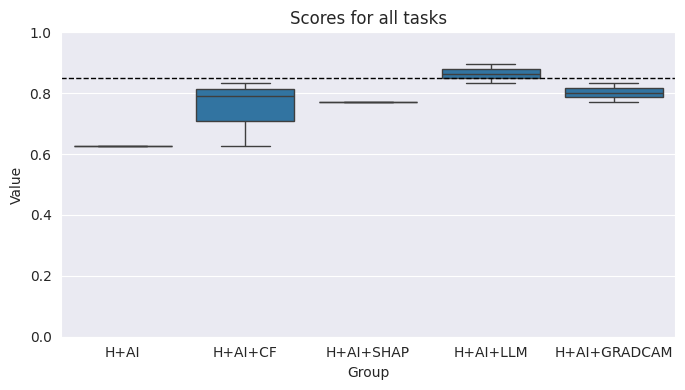

In [109]:
plot_boxplot(all_scores, group_name="Group", title="Scores for all tasks", y_lim=(0, 1), y_line=0.85)


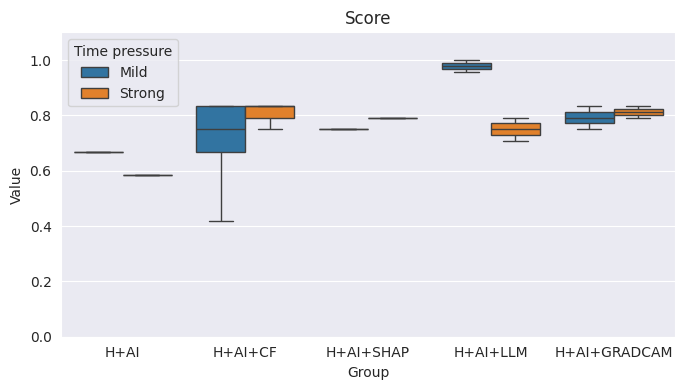

In [110]:
plot_boxplot_two(all_scores_mild, all_scores_strong, "Group", labels=["Mild", "Strong"], title="Score", dataset_name="Time pressure", y_lim=(0, 1.1))

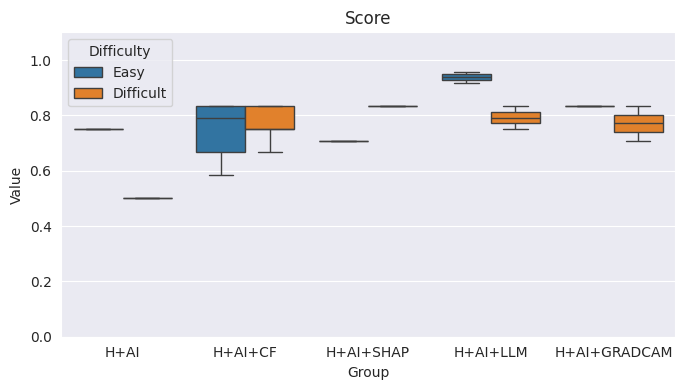

In [111]:
plot_boxplot_two(all_scores_easy, all_scores_difficult, "Group", labels=["Easy", "Difficult"], title="Score", dataset_name="Difficulty", y_lim=(0, 1.1))

In [112]:
all_reliance, all_overreliance

({'H': [],
  'H+AI': [0.7083333333333334],
  'H+AI+CF': [0.8958333333333334, 0.75, 0.625, 0.6875, 1.0],
  'H+AI+SHAP': [0.8541666666666666],
  'H+AI+LLM': [0.7916666666666666, 0.75],
  'H+AI+GRADCAM': [0.8541666666666666, 1.0]},
 {'H': [],
  'H+AI': [0.75],
  'H+AI+CF': [0.75, 0.625, 0.5, 0.125, 1.0],
  'H+AI+SHAP': [0.75],
  'H+AI+LLM': [0.375, 0.0],
  'H+AI+GRADCAM': [0.75, 1.0]})

In [113]:
all_reliance_easy, all_overreliance_easy

({'H': [],
  'H+AI': [0.75],
  'H+AI+CF': [0.9166666666666666,
   0.6666666666666666,
   0.5833333333333334,
   0.625,
   1.0],
  'H+AI+SHAP': [0.7916666666666666],
  'H+AI+LLM': [0.8333333333333334, 0.7916666666666666],
  'H+AI+GRADCAM': [0.9166666666666666, 1.0]},
 {'H': [],
  'H+AI': [0.5],
  'H+AI+CF': [0.75, 0.5, 0.5, 0.0, 1.0],
  'H+AI+SHAP': [0.75],
  'H+AI+LLM': [0.25, 0.0],
  'H+AI+GRADCAM': [0.75, 1.0]})

In [114]:
all_reliance_difficult, all_overreliance_difficult

({'H': [],
  'H+AI': [0.6666666666666666],
  'H+AI+CF': [0.875, 0.8333333333333334, 0.6666666666666666, 0.75, 1.0],
  'H+AI+SHAP': [0.9166666666666666],
  'H+AI+LLM': [0.75, 0.7083333333333334],
  'H+AI+GRADCAM': [0.7916666666666666, 1.0]},
 {'H': [],
  'H+AI': [1.0],
  'H+AI+CF': [0.75, 0.75, 0.5, 0.25, 1.0],
  'H+AI+SHAP': [0.75],
  'H+AI+LLM': [0.5, 0.0],
  'H+AI+GRADCAM': [0.75, 1.0]})

In [115]:
all_reliance_mild, all_overreliance_mild

({'H': [],
  'H+AI': [0.75],
  'H+AI+CF': [0.7916666666666666,
   0.5833333333333334,
   0.25,
   0.6666666666666666,
   1.0],
  'H+AI+SHAP': [0.75],
  'H+AI+LLM': [0.875, 0.8333333333333334],
  'H+AI+GRADCAM': [0.75, 1.0]},
 {'H': [],
  'H+AI': [0.75],
  'H+AI+CF': [0.5, 0.25, 0.0, 0.0, 1.0],
  'H+AI+SHAP': [0.5],
  'H+AI+LLM': [0.25, 0.0],
  'H+AI+GRADCAM': [0.5, 1.0]})

In [116]:
all_reliance_strong, all_overreliance_strong

({'H': [],
  'H+AI': [0.6666666666666666],
  'H+AI+CF': [1.0, 0.9166666666666666, 1.0, 0.7083333333333334, 1.0],
  'H+AI+SHAP': [0.9583333333333334],
  'H+AI+LLM': [0.7083333333333334, 0.6666666666666666],
  'H+AI+GRADCAM': [0.9583333333333334, 1.0]},
 {'H': [],
  'H+AI': [0.75],
  'H+AI+CF': [1.0, 1.0, 1.0, 0.25, 1.0],
  'H+AI+SHAP': [1.0],
  'H+AI+LLM': [0.5, 0.0],
  'H+AI+GRADCAM': [1.0, 1.0]})

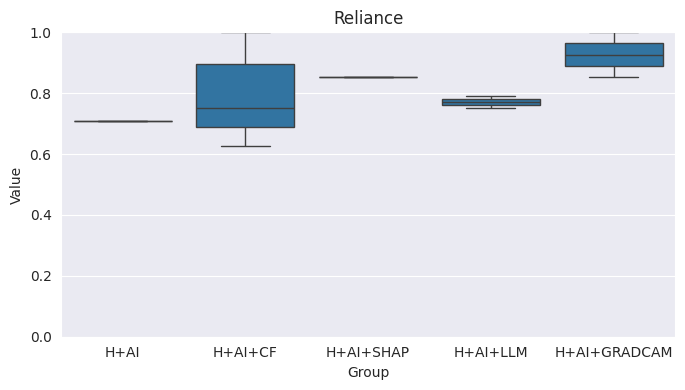

In [117]:
plot_boxplot(all_reliance, "Group", title="Reliance", y_lim=(0, 1))


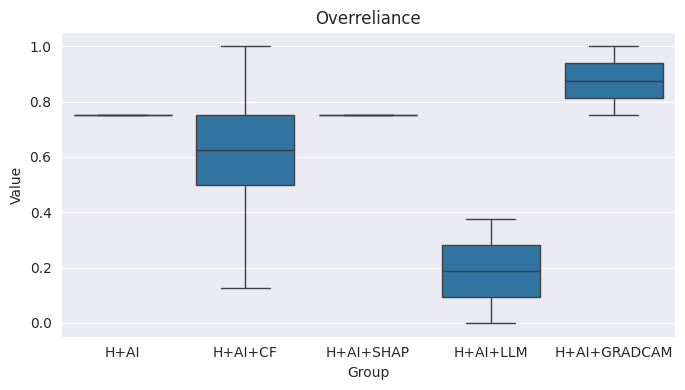

In [118]:
plot_boxplot(all_overreliance, "Group", title="Overreliance")


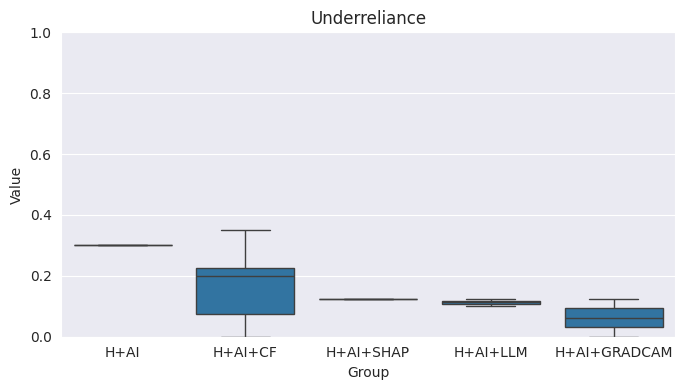

In [119]:
plot_boxplot(all_underreliance, "Group", title="Underreliance", y_lim=(0, 1))


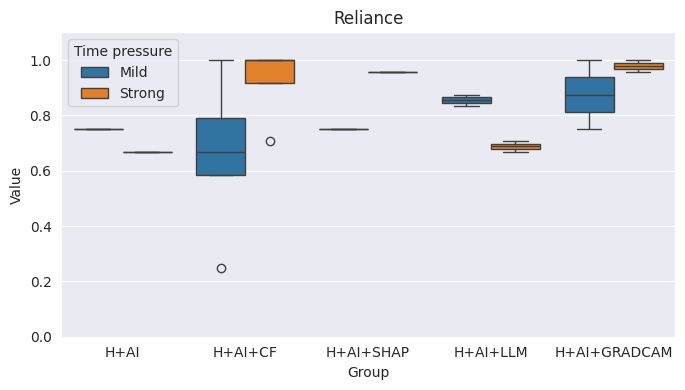

In [120]:
plot_boxplot_two(all_reliance_mild, all_reliance_strong, "Group", labels=["Mild", "Strong"], title="Reliance", dataset_name="Time pressure", y_lim=(0, 1.1))

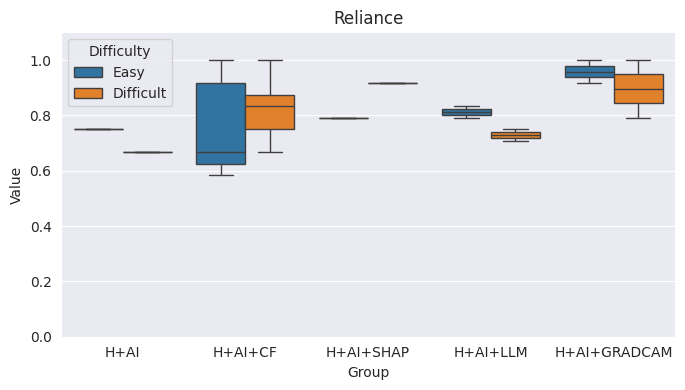

In [121]:
plot_boxplot_two(all_reliance_easy, all_reliance_difficult, "Group", labels=["Easy", "Difficult"], title="Reliance", dataset_name="Difficulty", y_lim=(0, 1.1))

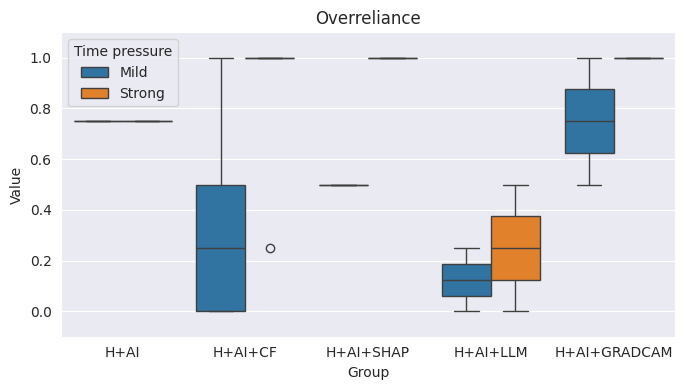

In [122]:
plot_boxplot_two(all_overreliance_mild, all_overreliance_strong, "Group", labels=["Mild", "Strong"], title="Overreliance", dataset_name="Time pressure",
                 y_lim=(-0.1, 1.1))

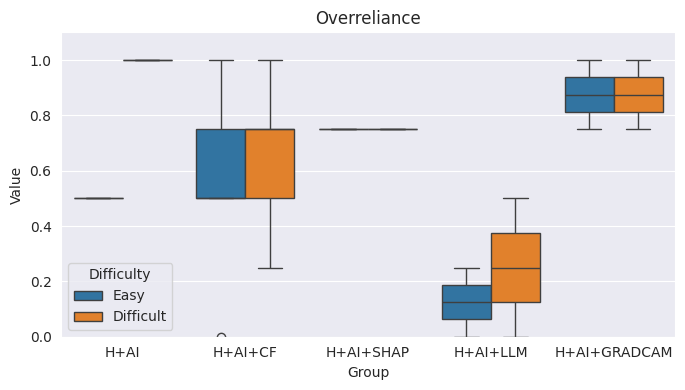

In [123]:
plot_boxplot_two(all_overreliance_easy, all_overreliance_difficult, "Group", labels=["Easy", "Difficult"], title="Overreliance", dataset_name="Difficulty", y_lim=(0, 1.1))

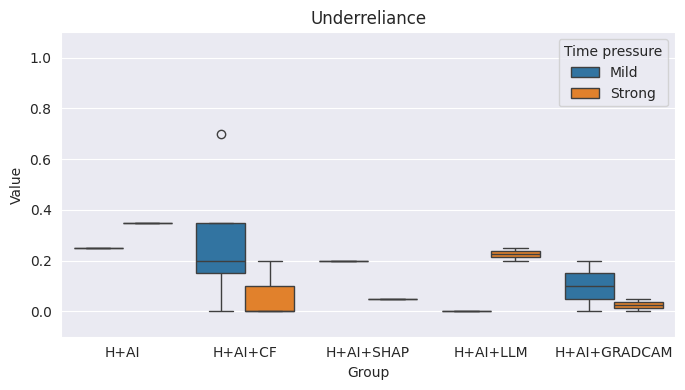

In [124]:
plot_boxplot_two(all_underreliance_mild, all_underreliance_strong, "Group", labels=["Mild", "Strong"], title="Underreliance", dataset_name="Time pressure",
                 y_lim=(-0.1, 1.1))

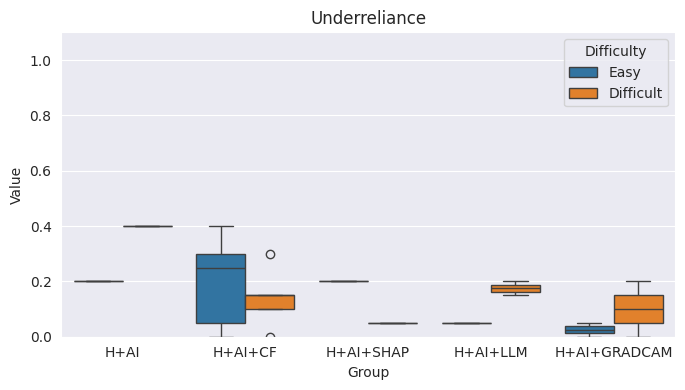

In [125]:
plot_boxplot_two(all_underreliance_easy, all_underreliance_difficult, "Group", labels=["Easy", "Difficult"], title="Underreliance", dataset_name="Difficulty", y_lim=(0, 1.1))

In [126]:
from pywebxaii.resretrieval import extract_total_times


def extract_times(results_dir, results_filenames_d):
    output_res_d = {}

    # Iterating over all groups
    for group_key, filenames_list in results_filenames_d.items():

        output_res_d[group_key] = []

        # Iterating on all results files for the current group
        for filename in filenames_list:
            curr_res_path = os.path.join(results_dir, filename)
            curr_res_d = load_json(curr_res_path)
            if not curr_res_d["is_completed"]:
                continue
            res_dict = load_json(curr_res_path)
            total_time, _ = extract_total_times(res_dict)

            output_res_d[group_key].append(total_time / 60)

    return output_res_d


In [127]:
times_data = extract_times(results_dir, results_filenames_d)

In [128]:
times_data

{'H': [],
 'H+AI': [20.472649999999998],
 'H+AI+CF': [17.29641666666667,
  20.646416666666667,
  19.82,
  15.46505,
  10.478233333333332],
 'H+AI+SHAP': [38.645599999999995],
 'H+AI+LLM': [27.320766666666668, 19.72758333333333],
 'H+AI+GRADCAM': [27.5837, 12.9537]}

In [129]:
alltimes = []
for k, v in times_data.items():
    alltimes.extend(v)
print({f"median : {np.median(alltimes)}"})

{'median : 19.82'}


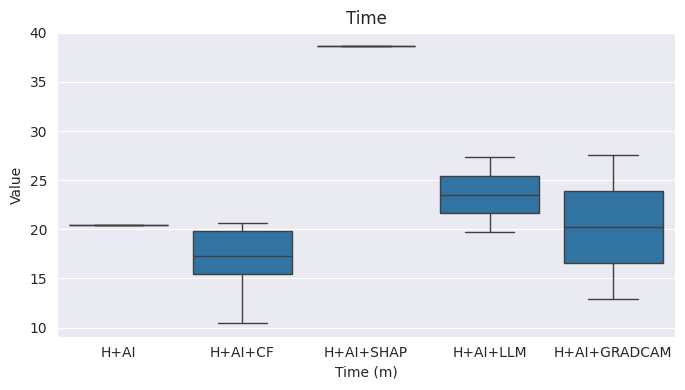

In [130]:
plot_boxplot(times_data, "Time (m)", title="Time")


In [131]:
def process_cogload(cogload_results):
    output_d = {}
    for k, v in cogload_results.items():
        output_d[k] = {}
        for session_id, results_list in v["raw"].items():

            if session_id == "mainexp_easy_mild_cogload":
                session_name = "easy;mild"
            elif session_id == "mainexp_easy_strong_cogload":
                session_name = "easy;strong"
            elif session_id == "mainexp_hard_mild_cogload":
                session_name = "hard;mild"
            elif session_id == "mainexp_hard_strong_cogload":
                session_name = "hard;strong"

            if session_id not in output_d:
                output_d[k][session_name] = []
            for result_arr in results_list:
                output_d[k][session_name].append(np.sum(result_arr))

    return output_d


In [132]:
quest_keys = ["mainexp_easy_mild_cogload", "mainexp_easy_strong_cogload", "mainexp_hard_mild_cogload",
              "mainexp_hard_strong_cogload"]

cogload_results = extract_quest_results(results_dir, results_filenames_d, protocol_paths_d, quest_keys)

In [133]:
# cogload_results

In [134]:
cogload_processed = process_cogload(cogload_results)

In [135]:
cogload_processed

{'H': {},
 'H+AI': {'easy;mild': [6],
  'easy;strong': [5],
  'hard;mild': [25],
  'hard;strong': [5]},
 'H+AI+CF': {'easy;mild': [6, 17, 22, 22, 18],
  'easy;strong': [9, 23, 10, 25, 16],
  'hard;mild': [16, 22, 22, 23, 19],
  'hard;strong': [6, 23, 3, 27, 22]},
 'H+AI+SHAP': {'easy;mild': [18],
  'easy;strong': [26],
  'hard;mild': [24],
  'hard;strong': [26]},
 'H+AI+LLM': {'easy;mild': [6, 19],
  'easy;strong': [17, 24],
  'hard;mild': [8, 23],
  'hard;strong': [24, 26]},
 'H+AI+GRADCAM': {'easy;mild': [25, 17],
  'easy;strong': [20, 19],
  'hard;mild': [22, 20],
  'hard;strong': [24, 18]}}

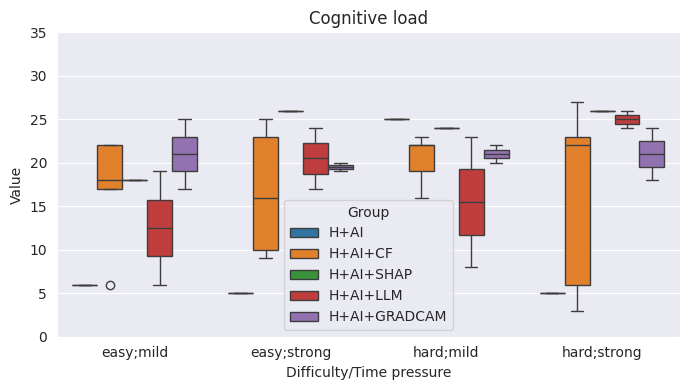

In [136]:
plot_boxplot_nested(
    cogload_processed,
    "Difficulty/Time pressure",
    dataset_name="Group",
    title="Cognitive load",
    y_lim=(0,35),
    y_line=None,
    figsize=(7, 4),
)

In [137]:

def plot_grouped_histograms(data, xlim, ylim=None, alpha=0.5, figsize=(12, 6), bins=None):
    """
    Plots histograms for nested group data.

    Parameters:
        data (dict):
            {
                "group1": {"groupA": [...], "groupB": [...], ...},
                "group2": {"groupA": [...], "groupB": [...], ...},
                ...
            }
        bins (int): Number of bins for histograms.
        alpha (float): Transparency for the overlapping histograms.
        figsize (tuple): Figure size.
    """

    # Get all subgroup names (e.g., groupA, groupB...)
    subgroups = sorted({sg for g in data.values() for sg in g.keys()})

    # Create one subplot per subgroup
    fig, axes = plt.subplots(1, len(subgroups), figsize=figsize, squeeze=False)
    axes = axes[0]

    # Prepare colors (matplotlib will cycle them automatically)
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    color_map = {gname: colors[i % len(colors)] for i, gname in enumerate(data.keys())}

    for ax, subgroup in zip(axes, subgroups):
        for group_name, group_dict in data.items():
            if subgroup in group_dict:
                values = group_dict[subgroup]
                if values:  # skip empty lists
                    ax.hist(values, alpha=alpha,
                            label=group_name, color=color_map[group_name], bins=bins)

        ax.set_title(subgroup)
        ax.set_xlabel("Value")
        ax.set_ylabel("Frequency")
        ax.set_xlim(xlim)
        if ylim is not None:
            ax.set_ylim(ylim)
        ax.legend()

    plt.tight_layout()
    plt.show()


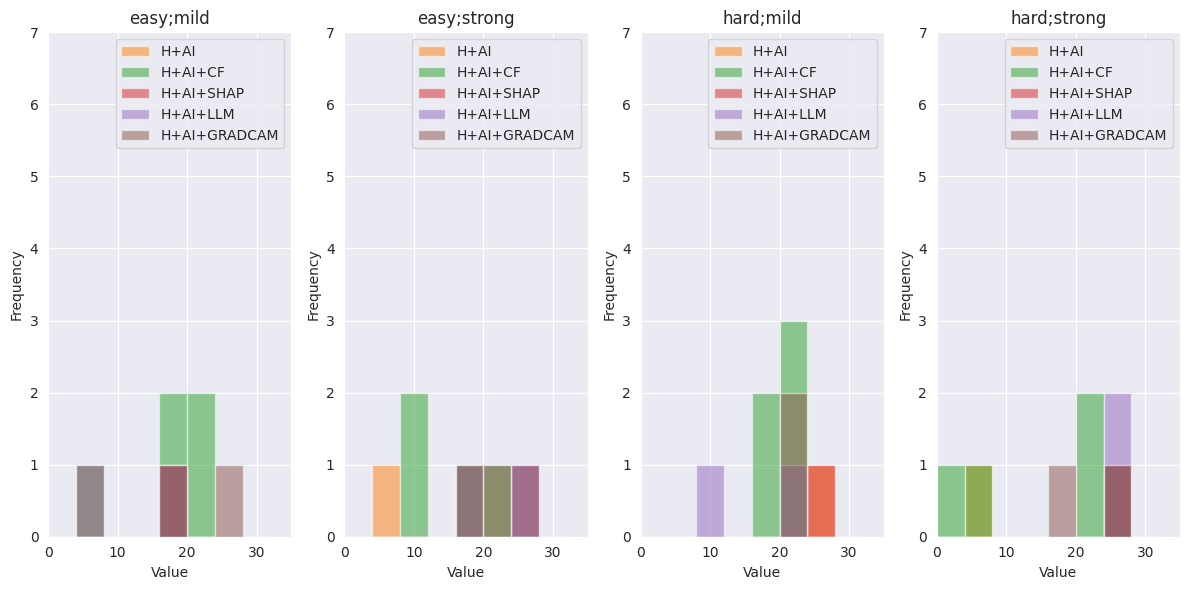

In [138]:
plot_grouped_histograms(cogload_processed, xlim=(0, 35), ylim=(0, 7), figsize=(12, 6), bins=np.arange(0, 35, 4))


In [139]:
quest_keys = ["mainexp_easy_mild_cogload", "mainexp_easy_strong_cogload", "mainexp_hard_mild_cogload",
              "mainexp_hard_strong_cogload"]

cogload_results = extract_quest_results(results_dir, results_filenames_d, protocol_paths_d, quest_keys)

In [140]:
# cogload_results

In [141]:
extract_quest_results(results_dir, results_filenames_d, protocol_paths_d, ["attentioncheck_1"])


{'H': {'raw': {}, 'values': {}, 'times': {}},
 'H+AI': {'raw': {'attentioncheck_1': [array([2, 0], dtype=object)]},
  'values': {'attentioncheck_1': [array(['(3) Somewhat Disagree', '(1) Blue'], dtype=object)]},
  'times': {'attentioncheck_1': [13731]}},
 'H+AI+CF': {'raw': {'attentioncheck_1': [array([2, 0], dtype=object),
    array([2, 0], dtype=object),
    array([2, 0], dtype=object),
    array([2, 0], dtype=object),
    array([2, 0], dtype=object)]},
  'values': {'attentioncheck_1': [array(['(3) Somewhat Disagree', '(1) Blue'], dtype=object),
    array(['(3) Somewhat Disagree', '(1) Blue'], dtype=object),
    array(['(3) Somewhat Disagree', '(1) Blue'], dtype=object),
    array(['(3) Somewhat Disagree', '(1) Blue'], dtype=object),
    array(['(3) Somewhat Disagree', '(1) Blue'], dtype=object)]},
  'times': {'attentioncheck_1': [7573, 15256, 18246, 6459, 4666]}},
 'H+AI+SHAP': {'raw': {'attentioncheck_1': [array([2, 0], dtype=object)]},
  'values': {'attentioncheck_1': [array(['(3)

In [142]:

extract_quest_results(results_dir, results_filenames_d, protocol_paths_d, ["attentioncheck_2"])


{'H': {'raw': {}, 'values': {}, 'times': {}},
 'H+AI': {'raw': {'attentioncheck_2': [array([6, 0], dtype=object)]},
  'values': {'attentioncheck_2': [array(['(7) Strongly Agree',
           '(1) Searching for patterns and their rotations'], dtype=object)]},
  'times': {'attentioncheck_2': [23599]}},
 'H+AI+CF': {'raw': {'attentioncheck_2': [array([6, 0], dtype=object),
    array([6, 0], dtype=object),
    array([6, 0], dtype=object),
    array([6, 0], dtype=object),
    array([6, 0], dtype=object)]},
  'values': {'attentioncheck_2': [array(['(7) Strongly Agree',
           '(1) Searching for patterns and their rotations'], dtype=object),
    array(['(7) Strongly Agree',
           '(1) Searching for patterns and their rotations'], dtype=object),
    array(['(7) Strongly Agree',
           '(1) Searching for patterns and their rotations'], dtype=object),
    array(['(7) Strongly Agree',
           '(1) Searching for patterns and their rotations'], dtype=object),
    array(['(7) Strongly

In [143]:
def process_reliance_list_data(reliance_data_list):

    output_trust = None

    if len(reliance_data_list) > 0:
        output_trust = reliance_data_list[0]

    return output_trust

def extract_declared_reliance_data(results_dir, results_filenames_d, protocol_paths_d):

    output_d = {}

    form_keys = ["mainexp_easy_mild_reliance",
            "mainexp_easy_strong_reliance",
            "mainexp_hard_mild_reliance",
            "mainexp_hard_strong_reliance"]

    data = extract_quest_results(results_dir, results_filenames_d, protocol_paths_d, form_keys)

    for key_group, data in data.items():
        output_d[key_group] = {}

        for form_key in form_keys:
            output_d[key_group][form_key] = {
                "trust": [],
            }

            if form_key not in data["raw"]:
                continue

            for arr in data["raw"][form_key]:
                trust = process_reliance_list_data(arr) if arr is not None else None

                if trust is not None:
                    output_d[key_group][form_key]["trust"].append(trust)

    return output_d


In [144]:
processed_reliance_data = extract_declared_reliance_data(results_dir, results_filenames_d, protocol_paths_d)


In [145]:
processed_reliance_data

{'H': {'mainexp_easy_mild_reliance': {'trust': []},
  'mainexp_easy_strong_reliance': {'trust': []},
  'mainexp_hard_mild_reliance': {'trust': []},
  'mainexp_hard_strong_reliance': {'trust': []}},
 'H+AI': {'mainexp_easy_mild_reliance': {'trust': [6]},
  'mainexp_easy_strong_reliance': {'trust': [5]},
  'mainexp_hard_mild_reliance': {'trust': [6]},
  'mainexp_hard_strong_reliance': {'trust': [5]}},
 'H+AI+CF': {'mainexp_easy_mild_reliance': {'trust': [4, 5, 2, 4, 4]},
  'mainexp_easy_strong_reliance': {'trust': [5, 5, 3, 4, 4]},
  'mainexp_hard_mild_reliance': {'trust': [4, 2, 3, 3, 5]},
  'mainexp_hard_strong_reliance': {'trust': [4, 3, 5, 4, 5]}},
 'H+AI+SHAP': {'mainexp_easy_mild_reliance': {'trust': [4]},
  'mainexp_easy_strong_reliance': {'trust': [2]},
  'mainexp_hard_mild_reliance': {'trust': [2]},
  'mainexp_hard_strong_reliance': {'trust': [4]}},
 'H+AI+LLM': {'mainexp_easy_mild_reliance': {'trust': [4, 4]},
  'mainexp_easy_strong_reliance': {'trust': [4, 4]},
  'mainexp_hard

In [146]:
def get_data_for_reliance_plots(processed_reliance_data, target_key):

    output_d = {k: {} for k in results_filenames_d.keys()}

    for group_key, group_data in processed_reliance_data.items():
        for form_key, form_data in group_data.items():
            output_d[group_key][form_key] = form_data[target_key]

    return output_d



In [147]:
declared_trust_plot_data = get_data_for_reliance_plots(processed_reliance_data, "trust")

In [148]:
declared_trust_plot_data

{'H': {'mainexp_easy_mild_reliance': [],
  'mainexp_easy_strong_reliance': [],
  'mainexp_hard_mild_reliance': [],
  'mainexp_hard_strong_reliance': []},
 'H+AI': {'mainexp_easy_mild_reliance': [6],
  'mainexp_easy_strong_reliance': [5],
  'mainexp_hard_mild_reliance': [6],
  'mainexp_hard_strong_reliance': [5]},
 'H+AI+CF': {'mainexp_easy_mild_reliance': [4, 5, 2, 4, 4],
  'mainexp_easy_strong_reliance': [5, 5, 3, 4, 4],
  'mainexp_hard_mild_reliance': [4, 2, 3, 3, 5],
  'mainexp_hard_strong_reliance': [4, 3, 5, 4, 5]},
 'H+AI+SHAP': {'mainexp_easy_mild_reliance': [4],
  'mainexp_easy_strong_reliance': [2],
  'mainexp_hard_mild_reliance': [2],
  'mainexp_hard_strong_reliance': [4]},
 'H+AI+LLM': {'mainexp_easy_mild_reliance': [4, 4],
  'mainexp_easy_strong_reliance': [4, 4],
  'mainexp_hard_mild_reliance': [5, 2],
  'mainexp_hard_strong_reliance': [2, 2]},
 'H+AI+GRADCAM': {'mainexp_easy_mild_reliance': [4, 6],
  'mainexp_easy_strong_reliance': [2, 6],
  'mainexp_hard_mild_reliance': 

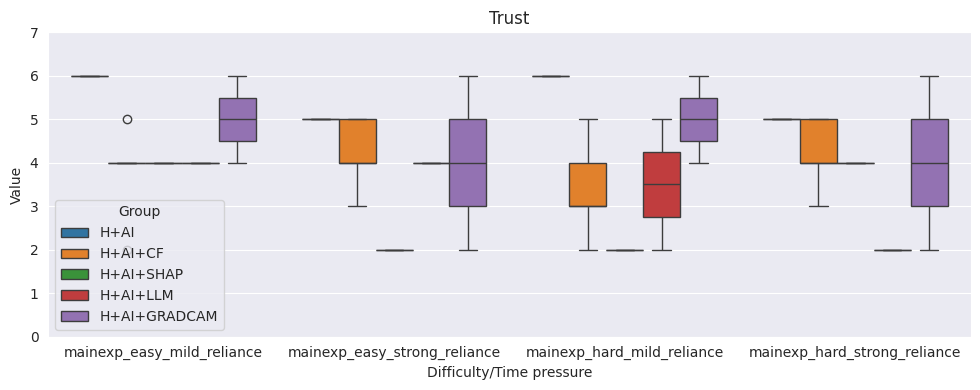

In [149]:
plot_boxplot_nested(
    declared_trust_plot_data,
    "Difficulty/Time pressure",
    dataset_name="Group",
    title="Trust",
    y_lim=(0,7),
    y_line=None,
    figsize=(10, 4),
)

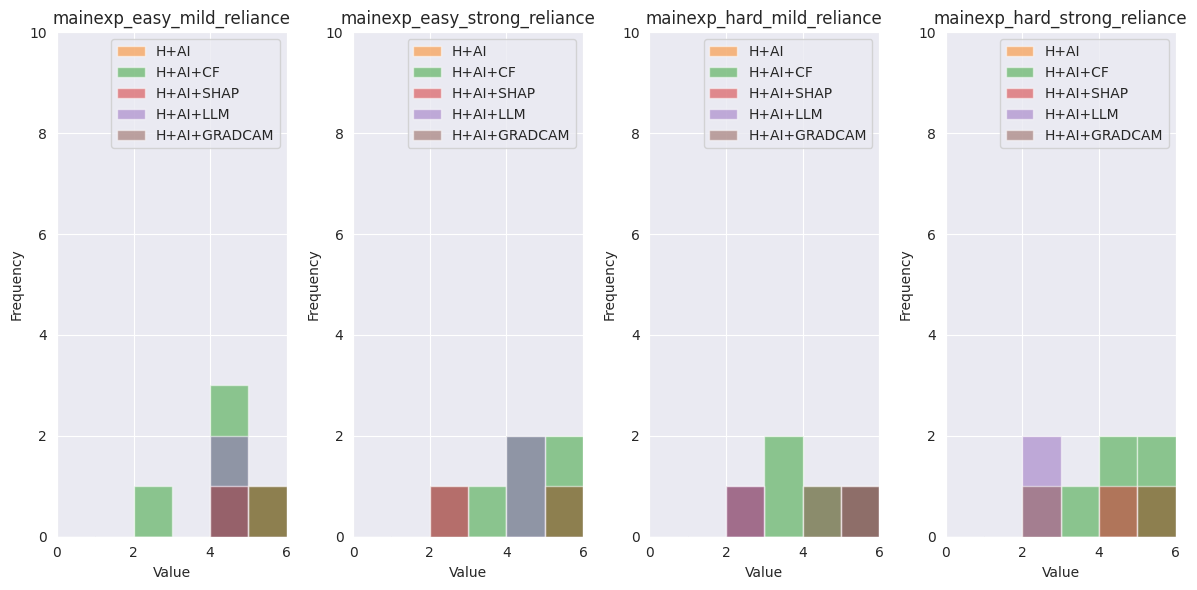

In [150]:
plot_grouped_histograms(declared_trust_plot_data, xlim=(0, 6), ylim=(0, 10), figsize=(12, 6), bins=np.arange(7))


In [151]:
all_reliance_strong

{'H': [],
 'H+AI': [0.6666666666666666],
 'H+AI+CF': [1.0, 0.9166666666666666, 1.0, 0.7083333333333334, 1.0],
 'H+AI+SHAP': [0.9583333333333334],
 'H+AI+LLM': [0.7083333333333334, 0.6666666666666666],
 'H+AI+GRADCAM': [0.9583333333333334, 1.0]}

In [152]:
scores_easy_mild, reliance_easy_mild, overreliance_easy_mild, underreliance_easy_mild, answertimes_easy_mild= compute_scores(results_dir, results_filenames_d, protocol_paths_d, tasks_dir, ["easy1_find_pattern_rot"], TASK_PROTOCOL_KEYS)
scores_easy_strong, reliance_easy_strong, overreliance_easy_strong, underreliance_easy_strong, answertimes_easy_strong = compute_scores(results_dir, results_filenames_d, protocol_paths_d, tasks_dir, ["easy3_find_pattern_rot"], TASK_PROTOCOL_KEYS)
scores_hard_mild, reliance_hard_mild, overreliance_hard_mild, underreliance_hard_mild, answertimes_hard_mild = compute_scores(results_dir, results_filenames_d, protocol_paths_d, tasks_dir, ["hard1_find_pattern_rot"], TASK_PROTOCOL_KEYS)
scores_hard_strong, reliance_hard_strong, overreliance_hard_strong, underreliance_hard_strong, answertimes_hard_strong = compute_scores(results_dir, results_filenames_d, protocol_paths_d, tasks_dir, ["hard3_find_pattern_rot"], TASK_PROTOCOL_KEYS)


In [153]:
processed_reliance_data

{'H': {'mainexp_easy_mild_reliance': {'trust': []},
  'mainexp_easy_strong_reliance': {'trust': []},
  'mainexp_hard_mild_reliance': {'trust': []},
  'mainexp_hard_strong_reliance': {'trust': []}},
 'H+AI': {'mainexp_easy_mild_reliance': {'trust': [6]},
  'mainexp_easy_strong_reliance': {'trust': [5]},
  'mainexp_hard_mild_reliance': {'trust': [6]},
  'mainexp_hard_strong_reliance': {'trust': [5]}},
 'H+AI+CF': {'mainexp_easy_mild_reliance': {'trust': [4, 5, 2, 4, 4]},
  'mainexp_easy_strong_reliance': {'trust': [5, 5, 3, 4, 4]},
  'mainexp_hard_mild_reliance': {'trust': [4, 2, 3, 3, 5]},
  'mainexp_hard_strong_reliance': {'trust': [4, 3, 5, 4, 5]}},
 'H+AI+SHAP': {'mainexp_easy_mild_reliance': {'trust': [4]},
  'mainexp_easy_strong_reliance': {'trust': [2]},
  'mainexp_hard_mild_reliance': {'trust': [2]},
  'mainexp_hard_strong_reliance': {'trust': [4]}},
 'H+AI+LLM': {'mainexp_easy_mild_reliance': {'trust': [4, 4]},
  'mainexp_easy_strong_reliance': {'trust': [4, 4]},
  'mainexp_hard

In [154]:
all_times_easy

{'H': [],
 'H+AI': [7.6,
  19.7,
  12.4,
  8.2,
  13.6,
  2.6,
  1.0,
  17.3,
  0.9,
  1.9,
  1.4,
  1.6,
  1.1,
  3.0,
  1.0,
  6.5,
  2.6,
  5.6,
  3.9,
  8.8,
  5.8,
  1.9,
  3.3,
  1.0],
 'H+AI+CF': [2.2,
  5.0,
  3.2,
  5.9,
  10.3,
  7.7,
  6.8,
  6.0,
  4.7,
  10.8,
  8.2,
  5.3,
  5.5,
  5.9,
  2.3,
  5.8,
  3.1,
  3.3,
  5.3,
  6.3,
  5.0,
  2.0,
  6.1,
  7.2,
  15.7,
  15.0,
  9.6,
  11.1,
  17.3,
  11.9,
  5.6,
  8.0,
  6.7,
  9.1,
  15.4,
  11.8,
  0.8,
  0.8,
  1.9,
  6.5,
  0.8,
  6.1,
  0.9,
  0.7,
  0.8,
  0.6,
  1.0,
  0.7,
  13.2,
  10.2,
  19.9,
  11.3,
  15.8,
  11.8,
  7.5,
  10.6,
  11.4,
  10.0,
  12.7,
  11.9,
  1.7,
  0.8,
  1.1,
  1.1,
  1.8,
  5.5,
  1.4,
  1.6,
  1.4,
  1.4,
  1.1,
  2.6,
  5.1,
  8.4,
  7.9,
  10.4,
  4.2,
  8.3,
  9.4,
  8.5,
  13.7,
  7.3,
  5.2,
  12.1,
  10.0,
  4.3,
  3.4,
  3.6,
  2.1,
  2.7,
  4.7,
  3.0,
  3.6,
  2.5,
  5.5,
  4.5,
  0.7,
  0.8,
  0.8,
  0.5,
  0.5,
  1.8,
  0.9,
  1.0,
  0.7,
  0.7,
  0.9,
  1.4,
  0.7,
  0.5,
  0.

In [155]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_histogram_with_density(data_dict, title="Histogram with Density", xlabel="Value", ylabel="Density"):
    """
    Plots a histogram with density (KDE) for each group in the data dictionary.

    Parameters:
    - data_dict: Dictionary of the form {"group1": [values], "group2": [values], ...}
    - title: Title of the plot
    - xlabel: Label for the x-axis
    - ylabel: Label for the y-axis
    """
    # Convert the dictionary to a DataFrame for easier plotting
    df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in data_dict.items()]))

    # Melt the DataFrame for seaborn
    df_melted = df.melt(var_name='groups', value_name='values')

    # Plot
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df_melted, x='values', hue='groups', kde=True, element='step', stat='density', common_norm=False)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()



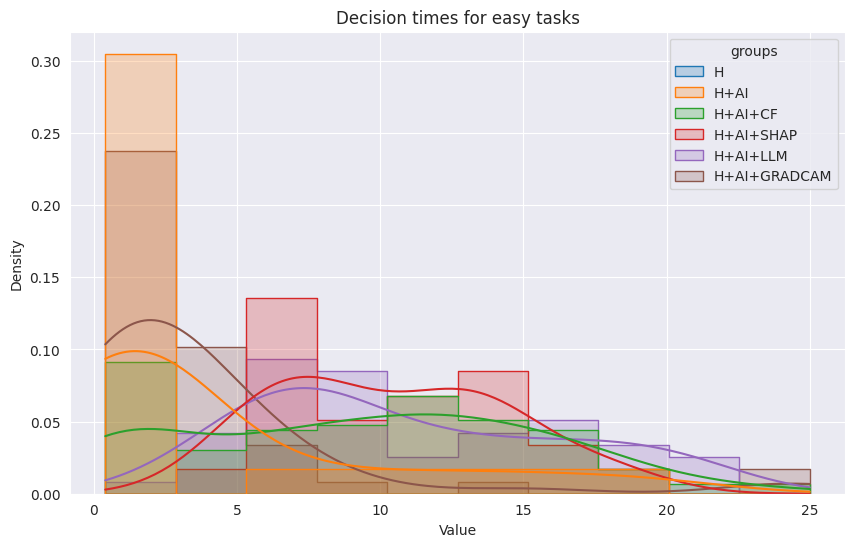

In [156]:
plot_histogram_with_density(all_times_mild, title="Decision times for easy tasks")

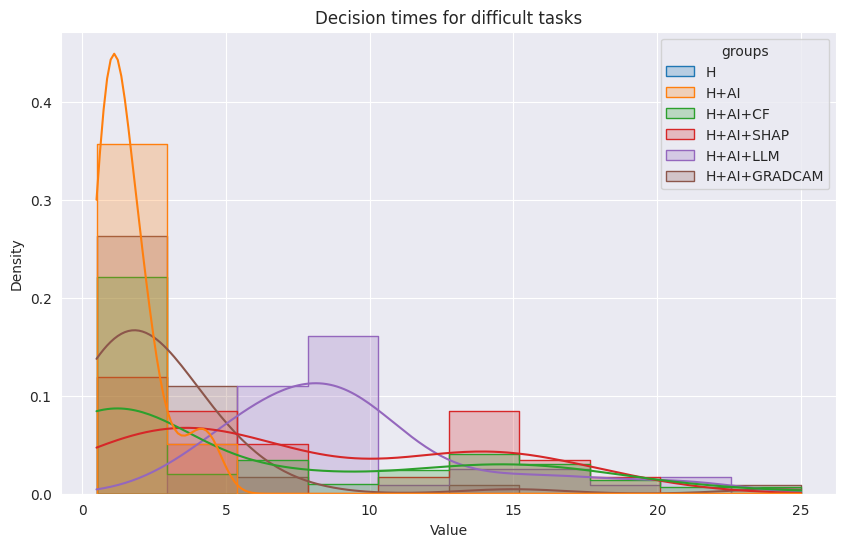

In [157]:
plot_histogram_with_density(all_times_difficult, title="Decision times for difficult tasks")

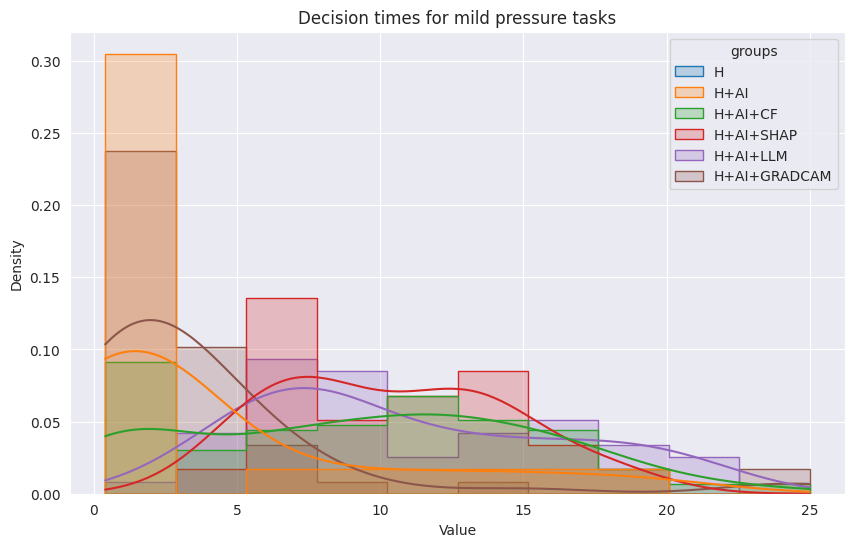

In [158]:
plot_histogram_with_density(all_times_mild, title="Decision times for mild pressure tasks")

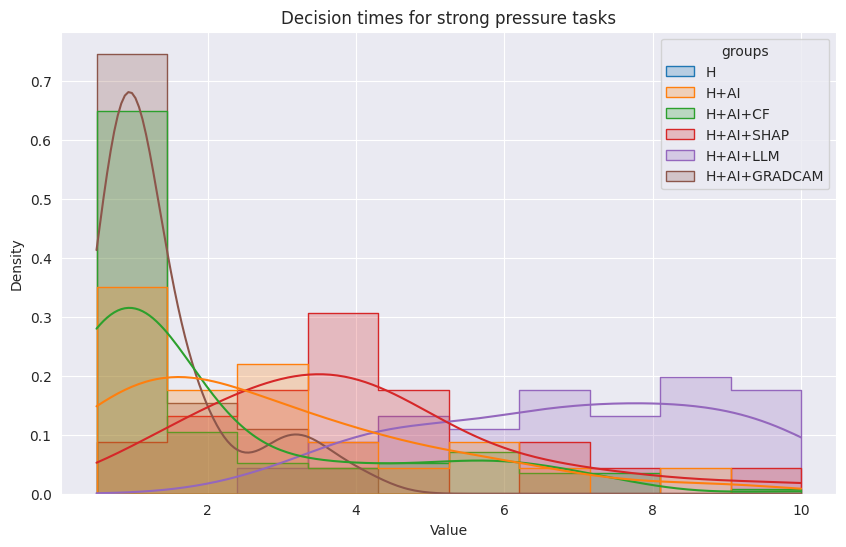

In [159]:
plot_histogram_with_density(all_times_strong, title="Decision times for strong pressure tasks")

In [160]:
N_per_group = 50

In [161]:
reliance_easy_mild["H+AI+SHAP"] = np.random.normal(0.6, 0.1, N_per_group).tolist()
reliance_easy_strong["H+AI+SHAP"] =  np.random.normal(0.7, 0.1, N_per_group).tolist()
reliance_hard_mild["H+AI+SHAP"] =  np.random.normal(0.7, 0.1, N_per_group).tolist()
reliance_hard_strong["H+AI+SHAP"] =  np.random.normal(0.9, 0.1, N_per_group).tolist()

reliance_easy_mild["H+AI+CF"] = np.random.normal(0.6, 0.1, N_per_group).tolist()
reliance_easy_strong["H+AI+CF"] =  np.random.normal(0.65, 0.1, N_per_group).tolist()
reliance_hard_mild["H+AI+CF"] =  np.random.normal(0.6, 0.1, N_per_group).tolist()
reliance_hard_strong["H+AI+CF"] =  np.random.normal(0.7, 0.1, N_per_group).tolist()

reliance_easy_mild["H"] = np.random.normal(0.5, 0.1, N_per_group).tolist()
reliance_easy_strong["H"] =  np.random.normal(0.5, 0.1, N_per_group).tolist()
reliance_hard_mild["H"] =  np.random.normal(0.5, 0.1, N_per_group).tolist()
reliance_hard_strong["H"] =  np.random.normal(0.5, 0.1, N_per_group).tolist()


In [162]:
reliance_easy_mild

{'H': [0.33262714901262314,
  0.47574478225801337,
  0.3286778633299041,
  0.5106515379902998,
  0.5583417096745029,
  0.5210716129539972,
  0.58681500058732,
  0.3366057589558459,
  0.6032103454190159,
  0.5138123248521788,
  0.5629535918825082,
  0.4268834866465484,
  0.5817720374064765,
  0.4997551897222495,
  0.5827067820101519,
  0.4132008555964181,
  0.5739230420306215,
  0.6073705418783911,
  0.8007705891872166,
  0.5421547083837595,
  0.5200636790667573,
  0.47427629751764866,
  0.27764309481467875,
  0.43538452836773933,
  0.4995503925768289,
  0.7415569813282468,
  0.42064800498971966,
  0.5536046400109378,
  0.3438854468225888,
  0.6166480334993433,
  0.39690935010547357,
  0.4688544103838202,
  0.5397761020477332,
  0.42589163862259527,
  0.4371187685126692,
  0.6380770688017422,
  0.5018318369690363,
  0.5714573654803128,
  0.5187153502685699,
  0.6301864752262313,
  0.6615258607117458,
  0.5155283707817414,
  0.5245126239560742,
  0.5747653898868338,
  0.5428282179457404,

In [163]:
def create_df():
    data_participants = []
    data_difficulty = []
    data_pressure = []
    data_reliance = []
    data_overreliance = []
    data_underreliance = []
    data_answertimes = []
    data_scores = []
    data_xai_condition = []
    data_trust = []

    for xai_condition in ["H", "H+AI", "H+AI+SHAP", "H+AI+CF", "H+AI+GRADCAM", "H+AI+LLM"]:

        data_reliance.extend(reliance_easy_mild[xai_condition])
        data_overreliance.extend(overreliance_easy_mild[xai_condition])
        data_underreliance.extend(underreliance_easy_mild[xai_condition])
        data_answertimes.extend(answertimes_easy_mild[xai_condition])
        data_scores.extend(scores_easy_mild[xai_condition])
        curr_trust_data = processed_reliance_data[xai_condition]["mainexp_easy_mild_reliance"]["trust"]
        data_trust.extend(curr_trust_data if curr_trust_data else [None for i in range(len(reliance_easy_mild[xai_condition]))])
        data_difficulty.extend(["easy" for k in range(len(reliance_easy_mild[xai_condition]))])
        data_pressure.extend(["mild" for k in range(len(reliance_easy_mild[xai_condition]))])
        data_participants.extend([i+1 for i in range(len(reliance_easy_mild[xai_condition]))])
        data_xai_condition.extend([xai_condition for k in range(len(reliance_easy_mild[xai_condition]))])

        data_reliance.extend(reliance_easy_strong[xai_condition])
        data_overreliance.extend(overreliance_easy_strong[xai_condition])
        data_underreliance.extend(underreliance_easy_strong[xai_condition])
        data_answertimes.extend(answertimes_easy_strong[xai_condition])
        data_scores.extend(scores_easy_strong[xai_condition])
        data_difficulty.extend(["easy" for k in range(len(reliance_easy_strong[xai_condition]))])
        curr_trust_data = processed_reliance_data[xai_condition]["mainexp_easy_strong_reliance"]["trust"]
        data_trust.extend(curr_trust_data if curr_trust_data else [None for i in range(len(reliance_easy_mild[xai_condition]))])
        data_pressure.extend(["strong" for k in range(len(reliance_easy_strong[xai_condition]))])
        data_participants.extend([i+1 for i in range(len(reliance_easy_strong[xai_condition]))])
        data_xai_condition.extend([xai_condition for k in range(len(reliance_easy_strong[xai_condition]))])

        data_reliance.extend(reliance_hard_mild[xai_condition])
        data_overreliance.extend(overreliance_hard_mild[xai_condition])
        data_underreliance.extend(underreliance_hard_mild[xai_condition])
        data_answertimes.extend(answertimes_hard_mild[xai_condition])
        data_scores.extend(scores_hard_mild[xai_condition])
        data_difficulty.extend(["hard" for k in range(len(reliance_hard_mild[xai_condition]))])
        curr_trust_data = processed_reliance_data[xai_condition]["mainexp_hard_mild_reliance"]["trust"]
        data_trust.extend(curr_trust_data if curr_trust_data else [None for i in range(len(reliance_easy_mild[xai_condition]))])
        data_pressure.extend(["mild" for k in range(len(reliance_hard_mild[xai_condition]))])
        data_participants.extend([i+1 for i in range(len(reliance_hard_mild[xai_condition]))])
        data_xai_condition.extend([xai_condition for k in range(len(reliance_hard_mild[xai_condition]))])

        data_reliance.extend(reliance_hard_strong[xai_condition])
        data_overreliance.extend(overreliance_hard_strong[xai_condition])
        data_underreliance.extend(underreliance_hard_strong[xai_condition])
        data_answertimes.extend(answertimes_hard_strong[xai_condition])
        data_scores.extend(scores_hard_strong[xai_condition])
        data_difficulty.extend(["hard" for k in range(len(reliance_hard_strong[xai_condition]))])
        curr_trust_data = processed_reliance_data[xai_condition]["mainexp_hard_strong_reliance"]["trust"]
        data_trust.extend(curr_trust_data if curr_trust_data else [None for i in range(len(reliance_easy_mild[xai_condition]))])
        data_pressure.extend(["strong" for k in range(len(reliance_hard_strong[xai_condition]))])
        data_participants.extend([i+1 for i in range(len(reliance_hard_strong[xai_condition]))])
        data_xai_condition.extend([xai_condition for k in range(len(reliance_hard_strong[xai_condition]))])

    print(len(data_participants))
    print(len(data_difficulty))
    print(len(data_pressure))
    print(len(data_reliance))
    print(len(data_overreliance))
    print(len(data_underreliance))
    print(len(data_scores))
    print(len(data_trust))
    print(len(data_xai_condition))
    return pd.DataFrame({
        "participant": data_participants,
        "difficulty": data_difficulty,
        "pressure": data_pressure,
        "reliance": data_reliance,
        "overreliance": data_overreliance,
        "underreliance": data_underreliance,
        "score": data_scores,
        "trust": data_trust,
        "xai_condition": data_xai_condition
    })


In [164]:
df = create_df()
# df["participant"] = df["participant"].astype("category")
df["pressure"] = df["pressure"].astype("category")
df["difficulty"] = df["difficulty"].astype("category")
df["xai_condition"] = df["xai_condition"].astype("category")

df["pressure"] = pd.Categorical(
    df["pressure"],
    categories=["mild", "strong"],
    ordered=True
)

df["difficulty"] = pd.Categorical(
    df["difficulty"],
    categories=["easy", "hard"],
    ordered=True
)

df["xai_condition"] = pd.Categorical(
    df["xai_condition"],
    categories=["H", "H+AI", "H+AI+CF", "H+AI+SHAP", "H+AI+LLM", "H+AI+GRADCAM"],
    ordered=False
)


620
620
620
620
44
44
44
244
620


ValueError: All arrays must be of the same length

,participant,difficulty,pressure,reliance,overreliance,underreliance,score,trust,xai_condition
36,1,easy,mild,0.583333,1.0,0.5,0.416667,3.0,H+AI
37,2,easy,mild,0.833333,0.0,0.0,1.000000,1.0,H+AI
38,3,easy,mild,1.000000,1.0,0.0,0.833333,1.0,H+AI
39,4,easy,mild,0.666667,0.0,0.2,0.833333,5.0,H+AI
40,5,easy,mild,0.666667,0.5,0.3,0.666667,4.0,H+AI
...,...,...,...,...,...,...,...,...,...
255,7,hard,strong,0.833333,1.0,0.2,0.666667,5.0,H+AI+LLM
256,8,hard,strong,0.750000,0.0,0.1,0.833333,4.0,H+AI+LLM
257,9,hard,strong,0.833333,0.0,0.0,0.916667,4.0,H+AI+LLM
258,10,hard,strong,0.916667,1.0,0.1,0.750000,4.0,H+AI+LLM


## Test of hypotheses

### Hypotheses 1 (related to time pressure)
Each hypothesis is tested for every group with AI, against the data of the same group
with no time pressure/difficulty. Effects of pressure and
difficulty are studied independently + their interaction

* (1.a) Higher time pressure and higher difficulty increase reliance.

In [373]:
import statsmodels.formula.api as smf

pvals = []
labels = []
for xai_group in ["H", "H+AI", "H+AI+CF", "H+AI+SHAP", "H+AI+LLM", "H+AI+GRADCAM"]:

    df_group = df[df["xai_condition"] == xai_group]
    print(xai_group)
    model = smf.mixedlm(
        "reliance ~ pressure * difficulty",
        df_group,
        groups=df_group["participant"]
    )
    result = model.fit()

    pval = result.pvalues["pressure[T.strong]:difficulty[T.hard]"]
    pvals.append(pval)
    labels.append(xai_group)

    print(result.summary())

from statsmodels.stats.multitest import multipletests

reject, pvals_holm, _, _ = multipletests(
    pvals,
    alpha=0.05,
    method="holm"
)

for g, p_raw, p_adj, sig in zip(labels, pvals, pvals_holm, reject):
    print(
        f"{g:12s}  raw p = {p_raw:.4f}  "
        f"Holm p = {p_adj:.4f}  "
        f"{'SIGNIFICANT' if sig else 'ns'}"
    )


H
                     Mixed Linear Model Regression Results
Model:                      MixedLM         Dependent Variable:         reliance
No. Observations:           36              Method:                     REML    
No. Groups:                 9               Scale:                      0.0160  
Min. group size:            4               Log-Likelihood:             16.3988 
Max. group size:            4               Converged:                  No      
Mean group size:            4.0                                                 
--------------------------------------------------------------------------------
                                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------
Intercept                              0.731    0.042 17.368 0.000  0.649  0.814
pressure[T.strong]                    -0.019    0.060 -0.311 0.756 -0.135  0.098
difficulty[T.hard]                    -0.074    

/home/jleguy/anaconda3/envs/Pytorch_exp/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/jleguy/anaconda3/envs/Pytorch_exp/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/jleguy/anaconda3/envs/Pytorch_exp/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/jleguy/anaconda3/envs/Pytorch_exp/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/home/jleguy/anaconda3/envs/Pytorch_exp/lib/python3.12/site-packages/statsmodels/base/model.py:607: Conve

                     Mixed Linear Model Regression Results
Model:                      MixedLM         Dependent Variable:         reliance
No. Observations:           56              Method:                     REML    
No. Groups:                 14              Scale:                      0.0198  
Min. group size:            4               Log-Likelihood:             22.8188 
Max. group size:            4               Converged:                  No      
Mean group size:            4.0                                                 
--------------------------------------------------------------------------------
                                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------
Intercept                              0.768    0.038 20.382 0.000  0.694  0.842
pressure[T.strong]                     0.012    0.053  0.224 0.823 -0.092  0.116
difficulty[T.hard]                    -0.000    0.

* (1.b) Higher time pressure and higher difficulty increase overreliance.

In [358]:
import statsmodels.formula.api as smf

model = smf.mixedlm(
    "overreliance ~ pressure * difficulty * xai_condition",
    df,
    groups=df["participant"]
)

result = model.fit()
print(result.summary())

                                    Mixed Linear Model Regression Results
Model:                              MixedLM                  Dependent Variable:                  overreliance
No. Observations:                   260                      Method:                              REML        
No. Groups:                         14                       Scale:                               0.1214      
Min. group size:                    4                        Log-Likelihood:                      -119.5046   
Max. group size:                    24                       Converged:                           Yes         
Mean group size:                    18.6                                                                      
--------------------------------------------------------------------------------------------------------------
                                                                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------

/home/jleguy/anaconda3/envs/Pytorch_exp/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


* (1.c) Higher time pressure and higher difficulty decrease trust.


In [364]:
df_H1c = df[df["xai_condition"] != "H"]

In [366]:
import statsmodels.formula.api as smf

model = smf.mixedlm(
    "trust ~ pressure * difficulty * xai_condition",
    data=df_H1c,
    groups=df_H1c["participant"]
)

result = model.fit()
print(result.summary())

/home/jleguy/anaconda3/envs/Pytorch_exp/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/jleguy/anaconda3/envs/Pytorch_exp/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


                                             Mixed Linear Model Regression Results
Model:                                    MixedLM                         Dependent Variable:                         trust    
No. Observations:                         224                             Method:                                     REML     
No. Groups:                               14                              Scale:                                      1.7821   
Min. group size:                          4                               Log-Likelihood:                             -309.8241
Max. group size:                          20                              Converged:                                  No       
Mean group size:                          16.0                                                                                 
-------------------------------------------------------------------------------------------------------------------------------
                     

/home/jleguy/anaconda3/envs/Pytorch_exp/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/jleguy/anaconda3/envs/Pytorch_exp/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/home/jleguy/anaconda3/envs/Pytorch_exp/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/jleguy/anaconda3/envs/Pytorch_exp/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/home/jleguy/anaconda3/envs/Pytorch_exp/lib/python3.12